# HW Overview

Please complete all core assignment tasks. Optional tasks do not carry any points but are highly recommended.

The goals of this HW include the following:
* master pipelines for regression prediction problems
  * Exploratory data analysis
  * Date preprocessing
    * Data standardization
    * Deal with missing data
    * Dealing with categorical input features via, say, OHE 
  * Linear regression with regularization
  * Various performance metrics
  
  
Please consult Canvas for the grading rubric (check Module 05 -> HW 05).


# Evaluation metrics for Regression Models

Importing Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore") 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

##  Mean absolute percentage error (MAPE)
There is no MAPE implementation in sklearn (because this metric is undefined when real value is zero). Below one can find my own implementation.

The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics, for example in trend estimation. It usually expresses accuracy as a percentage, and is defined by the formula:

$${\displaystyle {\mbox{M}}={\frac {100\%}{n}}\sum _{t=1}^{n}\left|{\frac {A_{t}-F_{t}}{A_{t}}}\right|,} $$
where At is the actual value and Ft is the forecast value.

The difference between At and Ft is divided by the Actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.

Although the concept of MAPE sounds very simple and convincing, it has major drawbacks in practical application 

It cannot be used if there are zero values (which sometimes happens for example in demand data) because there would be a division by zero.
For forecasts which are too low the percentage error cannot exceed 100%, but for forecasts which are too high there is no upper limit to the percentage error.
When MAPE is used to compare the accuracy of prediction methods it is biased in that it will systematically select a method whose forecasts are too low. This little-known but serious issue can be overcome by using an accuracy measure based on the ratio of the predicted to actual value (called the Accuracy Ratio), this approach leads to superior statistical properties and leads to predictions which can be interpreted in terms of the geometric mean.

For more details on MAPE please see [here](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Use of this metric is not recommended because can cause division by zero
    See other regression metrics on sklearn docs:
      http://scikit-learn.org/stable/modules/classes.html#regression-metrics
    Use like any other metric
    >>> y_true = [3, -0.5, 2, 7]; y_pred = [2.5, -0.3, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    Out[]: 24.791666666666668
    """

    return np.mean(np.abs((y_true.ravel() - y_pred.ravel()) / y_true.ravel())) * 100

Let's evaluate our model according to three different metrics:
* MAE (Mean Absolute Error)
* RMSE (Root Mean Squared Error)
* MAPE (Mean Absolute Percentage Error)

In [3]:
metrics = [mean_absolute_error, 
           lambda y_true, y_pred: mean_squared_error(y_true, y_pred) ** 0.5, 
           mean_absolute_percentage_error]
metrics_names = ["MAE", 
                 "RMSE", 
                 "MAPE"]

In [4]:
def evaluate(models, metrics, samples, metrics_names, models_names):
    results = np.zeros((len(samples) * len(models), len(metrics)))
    samples_names = []
    for m in models_names:
        samples_names.extend([m + " Train", m + " Test"])
    for m_num, model in enumerate(models):
        for row, sample in enumerate(samples):
            for col, metric in enumerate(metrics):
                results[row + m_num * 2, col] = np.round(metric(sample[1], model.predict(sample[0])), decimals=3)
    results = pd.DataFrame(results, columns=metrics_names, index=samples_names)
    return results

# Core task: bike demand extension 2 (target = log(demand+1))

The distribution of the raw `count` feature is very skewed with most values occuring to the left of the count domain. To make this distribution less skewed (and more normal distributed, it is common to take the log of the value + 1 (to avoid log(0)). 

* log(count+1)
* then just do regression as usual
* Do NOT forget to take the inverse of the log(count +1) before doing a Kaggle submissions. e.g., np.exp(pred) - 1 to get back to real count scale.

Overall, we want you to build a linear regression model (single model will suffice based on the `count` target) using pipelines that builds on what you learned as a solution to the previous section,   and do a Kaggle submission for this Bike Demand prediction problem. In particular, we want you to address (using what you have done previously) the following:

* Derive other features 
  * OHE features such as  season, 
  * If barplot demand over each hour of the the day, you will notice interesting patterns. E.g., you might be able to  segregate the bike demand in three hourly categories, like the following:

      ```
         High       : 7-9 and 17-19 hours
         Average    : 10-16 hours
         Low        : 0-6 and 20-24 hours
```
* Perform feature selection using `Sequential Backward Selection` algorithm
  * See a full section on Sequential Backward Selection for regression in Lab05 Notebook for details on how to do this. 
* Please put all modeling steps in a Pipeline 
  * NOTE please keep the OHE step separate preprocessing step for this homework
  * Feature Selection can be performed prior to the pipeline or as part of the pipeline. Please discuss what you choose and why.
* Present your experimental results in tabular form
  * Describe the linear regression model, number of input features used, MAE, RMSE and MAPE, feature familires used (e.g., Baseline features, Season OHE, etc.).
* Please do a Kaggle submission with your best linear regression model
    * Screenshot your kaggle submission results
* Discuss your best result (in terms of process followed, features used and any other interesting discoveries that you came across). Were the selected features here the same as what you selected in your solution to Section 6? 



## Load data

### Reload training data

In [5]:
train=pd.read_csv('Kaggle-Bike-Sharing-Demand-Challenge/train.csv')
train.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16


### OHE for wather and season; generate time and date features

In [6]:
train['weather1'] = np.where(train['weather']==1, 1, 0)  #ifelse assignment
train['weather2'] = np.where(train['weather']==2, 1, 0)
train['weather3'] = np.where(train['weather']==3, 1, 0)
train['weather4'] = np.where(train['weather']==4, 1, 0)

train['season1'] = np.where(train['season']==1, 1, 0)  #ifelse assignment
train['season2'] = np.where(train['season']==2, 1, 0)
train['season3'] = np.where(train['season']==3, 1, 0)
train['season4'] = np.where(train['season']==4, 1, 0)

train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1}) #OHE: One-hot-encoding (OHE): based 

# dont forget to drop the original feature
train.drop(['season', 'weather'], axis=1, inplace=True)

### Prepare the train data

Separate x, y from the train data and log transform y

In [7]:
X, y = train.iloc[:, 1:], train['count']
X = X.drop(['registered', 'casual', 'count'], axis=1)

# transform y
#==================================================#
#               Your code starts here              #
#==================================================#
y = np.log(y+1)
# TODO - change above to
# y = ...
#==================================================#
#               Your code ends here                #
#==================================================#               

Note that zeros no longer dominate other target values in transformed data

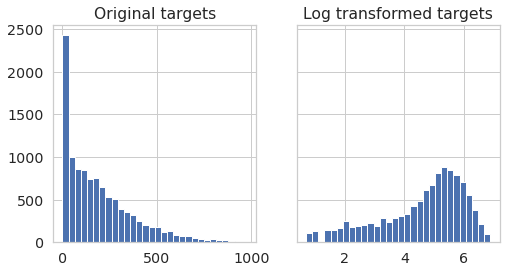

In [8]:
### Visualize target transformation
fig, ax = plt.subplots(1,2,sharey=True)
fig.set_figwidth(8)
ax[0].hist(train['count'], bins=30)
ax[0].set_title('Original targets')
ax[1].hist(y, bins=30)
ax[1].set_title('Log transformed targets');

In [9]:
np.random.seed(42)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=0)

## Sequential Backward Selection

In [10]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)
        
        print(X_train.shape, y_train.shape)
        print(X_test.shape, y_test.shape)
        dim = X_train.shape[1]
        self.indices_ = list(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, list(p))
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train.iloc[:, indices], y_train)
        y_pred = self.estimator.predict(X_test.iloc[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [11]:
from sklearn.metrics import explained_variance_score

np.random.seed(42)

# set up SBS: use linear regression estimator with default parameters
#==================================================#
#               Your code starts here              #
#==================================================#
lr = LinearRegression()
sbs = SBS(lr, 1, scoring=explained_variance_score)
# TODO - change above to
# lr = ...
# sbs = SBS(lr, ...)
#==================================================#
#               Your code ends here                #
#==================================================#               

sbs.fit(X_train, y_train)

(6531, 18) (6531,)
(2177, 18) (2177,)


Beyond 5 features there is not much additional benefit in terms of explained variance.

Text(0.5, 0, 'number of features')

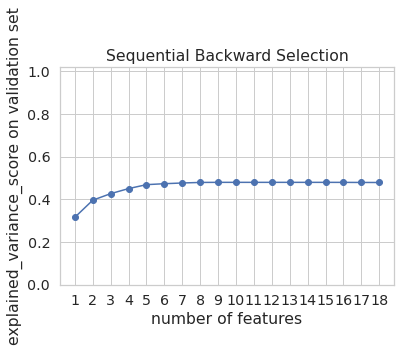

In [12]:
# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

#plot places the points on the graph using the number of features (no need to sort!)
plt.plot(k_feat, sbs.scores_, marker='o')  
plt.xticks(k_feat)
plt.ylim([0.0, 1.02])
plt.title("Sequential Backward Selection")
plt.ylabel('explained_variance_score on validation set')
plt.xlabel(r'number of features')

Modify TopFeatureSelector to select the k-th subset our SBS object

In [13]:
class SBSFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, subsets, k):
        self.subsets = subsets
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = sbs.subsets_[len(self.subsets)-self.k]  # pull the k-th subset from the end
        return self
    # select the columns of data matrix of the selected input features 
    def transform(self, X):
        return X[:, self.feature_indices_]

## Build a regression model (with a Pipeline)

In [14]:
np.random.seed(42)

# set up the pipeline with scaler, SBS selector, and estimator
# use k=5
#==================================================#
#               Your code starts here              #
#==================================================#
pipe = Pipeline([
        ("std_scaler", StandardScaler()),
        ('feature_selection', SBSFeatureSelector(sbs.subsets_, k=5)),
        ('linreg', LinearRegression())])
# TODO - change above to
# pipe = ...
#==================================================#
#               Your code ends here                #
#==================================================#    

pipe.fit(X_train, y_train)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('feature_selection',
                 SBSFeatureSelector(k=5,
                                    subsets=[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                              11, 12, 13, 14, 15, 16, 17],
                                             (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17),
                                             (2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17),
                                             (2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 16, 17),
                                             (2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 14, 16, 17),
                                             (2, 3, 4, 5, 6, 8, 9, 10, 11, 12,
                                              14, 

### Generate predictions

In [15]:
y_val_pred = pipe.predict(X_val)

### Present results

In [16]:
expLog = pd.DataFrame(columns=['Model Description', 'MAE', 'RMSE', "MAPE"])

In [17]:
mae = np.round(mean_absolute_error(y_val, y_val_pred), 3)
rmse = np.round(np.sqrt(mean_squared_error(y_val, y_val_pred)), 3)
#==================================================#
#               Your code starts here              #
#==================================================#
mape = np.round(mean_absolute_percentage_error(y_val, y_val_pred), 3)
# TODO - change above to
# mape = np.round(..., 3)
#==================================================#
#               Your code ends here                #
#==================================================#
expLog.loc[len(expLog)] = ['SKLearn LinReg SBS=5 Log Targets', mae, rmse, mape]

In [18]:
expLog

,Model Description,MAE,RMSE,MAPE
0,SKLearn LinReg SBS=5 Log Targets,0.816,1.03,27.507


## Prepare a Kaggle submisison

### Load and preprocess Kaggle test data

In [19]:
test=pd.read_csv('./Kaggle-Bike-Sharing-Demand-Challenge/test.csv')

In [20]:
# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
test['weather1'] = np.where(test['weather']==1, 1, 0)  #ifelse assignment
test['weather2'] = np.where(test['weather']==2, 1, 0)
test['weather3'] = np.where(test['weather']==3, 1, 0)
test['weather4'] = np.where(test['weather']==4, 1, 0)

# dont forget to drop the original feature
test.drop(['weather'], axis=1, inplace=True)

In [21]:
# Create a new column called df.season1 where the value is 1
# if df.season is 1 and 0 if not
test['season1'] = np.where(test['season']==1, 1, 0)  #ifelse assignment
test['season2'] = np.where(test['season']==2, 1, 0)
test['season3'] = np.where(test['season']==3, 1, 0)
test['season4'] = np.where(test['season']==4, 1, 0)

# dont forget to drop the original feature
test.drop(['season'], axis=1, inplace=True)

In [22]:
test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})

In [23]:
X_test = test.iloc[:,1:]

### Generate predictions using pipeline and best features (as determined by SBS) only

#### Generate predictions

In [24]:
y_pred_log = pipe.predict(X_test)

#### Transform back to original scale and integer values (counts)

In [25]:
#==================================================#
#               Your code starts here              #
#==================================================#
y_pred = np.exp(y_pred_log)-1
y_pred = np.round(y_pred).astype(int)
# TODO - change above to
# y_pred = ...
#==================================================#
#               Your code ends here                #
#==================================================#    

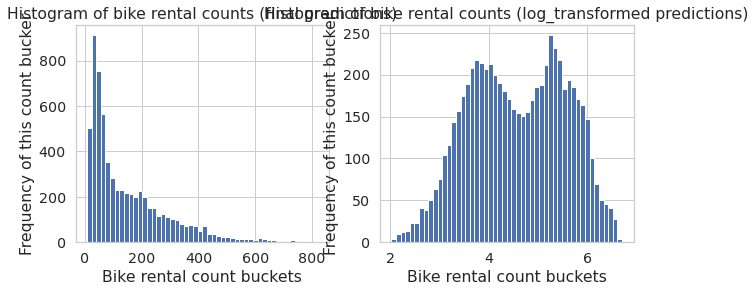

In [26]:
# Compare original target distribution with log transformed distribution

plt.figure(figsize=(10,4))
plt.subplot(121)
n, bins, patches = plt.hist(y_pred, 50)
plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucker')
plt.title(r'Histogram of bike rental counts (final predictions)')
plt.grid(True)
plt.subplot(122)
n, bins, patches = plt.hist(y_pred_log, 50)

plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucker')
plt.title(r'Histogram of bike rental counts (log_transformed predictions)')
plt.grid(True)
plt.show()

### Present Kaggle predictions in the format required for submission

In [27]:
# create dataframe in the form expected by Kaggle
df_submit = pd.DataFrame({'datetime':test['datetime'],'count':y_pred})
df_submit = df_submit[['datetime','count']]
# Hint: use head()
#==================================================#
#               Your code starts here              #
#==================================================#
df_submit.head(10)
# TODO - change above to
# ...
#==================================================#
#               Your code ends here                #
#==================================================#


,datetime,count
0,2011-01-20 00:00:00,12
1,2011-01-20 01:00:00,13
2,2011-01-20 02:00:00,15
3,2011-01-20 03:00:00,16
4,2011-01-20 04:00:00,18
5,2011-01-20 05:00:00,18
6,2011-01-20 06:00:00,20
7,2011-01-20 07:00:00,23
8,2011-01-20 08:00:00,26
9,2011-01-20 09:00:00,31


In [28]:
df_submit.to_csv('bike4.csv', index=False)

#  Core task: bike demand extension 3 (LR +  Regularization)

## L1 and L2 regularization for Linear Regression
Regularization is a way of penalizing the model for excessive complexity, and this helps reduce the risk of  overfitting.

There are many ways of doing regularization but these two are the major ones:
* **L2-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \sum_{j=1}^{m}w_j^2
$$
or in matrix way:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_2^2
$$
* **L1-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \sum_{j=1}^{m}|w_j|
$$
or in matrix way:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_1
$$

Use SKLearn Ridge and LASSO linear regression classes to perform feature selection. Use gridsearch to determine best value for $\alpha$ the mixing coefficent associated with the penalty term in regularized linear regression.

* Please put all modeling steps in a Pipeline
* NOTE please keep the OHE step separate preprocessing step for this homework
* Present your experimental results in tabular form
* Describe the linear regression model, number of input features used, MAE, RMSE and MAPE, feature familires used (e.g., Baseline features, Season OHE, etc.).
* Please do a Kaggle submission with your best linear regression model
    * Screenshot your kaggle submission results
* Discuss your best result (in terms of process followed, features used and any other interesting discoveries that you came across). Were the selected features here the same as what you selected in your solution to Section 8?

## Reload and restore the training data

In [29]:
train=pd.read_csv('Kaggle-Bike-Sharing-Demand-Challenge/train.csv')

train['weather1'] = np.where(train['weather']==1, 1, 0)  #ifelse assignment
train['weather2'] = np.where(train['weather']==2, 1, 0)
train['weather3'] = np.where(train['weather']==3, 1, 0)
train['weather4'] = np.where(train['weather']==4, 1, 0)

train['season1'] = np.where(train['season']==1, 1, 0)  #ifelse assignment
train['season2'] = np.where(train['season']==2, 1, 0)
train['season3'] = np.where(train['season']==3, 1, 0)
train['season4'] = np.where(train['season']==4, 1, 0)

train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1}) #OHE: One-hot-encoding (OHE): based 

# dont forget to drop the original feature
train.drop(['season', 'weather'], axis=1, inplace=True)

X, y = train.iloc[:, 1:], train['count']
X = X.drop(['registered', 'casual', 'count'], axis=1)

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

## Build GridSearch pipeline to compare alpha combinations using Ridge and Lasso 

In [30]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [31]:
np.random.seed(42)

estimators = [('ridge', Ridge()),
              ('lasso', Lasso())]

best_score = []
best_param = []
for estimator in estimators:
    params = {estimator[0]+'__alpha':[.01, .05, .1, .5, 1, 5]}
    # set up the pipeline using the standard scaler and estimator
    # and grid search with pipeline, params, 
    # and correct scoring parameter (scoring parameter has to be a utility- where bigger is better 
    # such as neg_mean_squared_error, explained_variance etc. )
    # for more information see the following - 
    #     https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    # Please use neg_mean_squared_error here.
    #==================================================#
    #               Your code starts here              #
    #==================================================#
    pipe = Pipeline([('scalar', StandardScaler()), estimator])
    gs = GridSearchCV(pipe, params, scoring='neg_mean_squared_error', cv=5)
    # TODO - change above to
    # pipe = ...
    # gs = GridSearchCV(..., cv=5)
    #==================================================#
    #               Your code ends here                #
    #==================================================#
    
    gs.fit(X_train, y_train)
    best_score.append(gs.best_score_)
    best_param.append(gs.best_params_)
best_idx = np.argmax(best_score)
print('Best model is:', estimators[best_idx][0], 'with parameter', best_param[best_idx])

Best model is: lasso with parameter {'lasso__alpha': 0.5}


## Generate predictions using best combination and report results in table

In [32]:
list(best_param[best_idx].values())[0]

0.5

In [33]:
#estimator = estimators[best_idx][0], list(best_param[best_idx].values())[0])
estimator = [Ridge, Lasso][best_idx]
param = list(gs.best_params_.values())[0]
print (param)
# set up the pipeline using the best estimator
pipe = Pipeline([('scalar', StandardScaler()), ('estimator', estimator(alpha=param))])
pipe.fit(X_train, y_train)

0.5


Pipeline(steps=[('scalar', StandardScaler()), ('estimator', Lasso(alpha=0.5))])

In [34]:
y_pred = pipe.predict(X_test)

In [35]:
mae = np.round(mean_absolute_error(y_pred, y_test), 3)
rmse = np.round(np.sqrt(mean_squared_error(y_pred, y_test)), 3)
#==================================================#
#               Your code starts here              #
#==================================================#
mape = np.round(mean_absolute_percentage_error(y_test, y_pred), 3)
# TODO - change above to
# mape = np.round(..., 3)
#==================================================#
#               Your code ends here                #
#==================================================#
expLog.loc[len(expLog)] = ['SKLearn Linear Regression GS (best regularization and alpha)', mae, rmse, mape]

In [36]:
expLog

,Model Description,MAE,RMSE,MAPE
0,SKLearn LinReg SBS=5 Log Targets,0.816,1.030,27.507
1,SKLearn Linear Regression GS (best regularizat...,105.472,140.201,354.104


## Prepare a Kaggle submission

### Load and preprocess Kaggle test data

In [37]:
test=pd.read_csv('./Kaggle-Bike-Sharing-Demand-Challenge/test.csv')

In [38]:
# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
test['weather1'] = np.where(test['weather']==1, 1, 0)  #ifelse assignment
test['weather2'] = np.where(test['weather']==2, 1, 0)
test['weather3'] = np.where(test['weather']==3, 1, 0)
test['weather4'] = np.where(test['weather']==4, 1, 0)

# dont forget to drop the original feature
test.drop(['weather'], axis=1, inplace=True)

# Create a new column called df.season1 where the value is 1
# if df.season is 1 and 0 if not
test['season1'] = np.where(test['season']==1, 1, 0)  #ifelse assignment
test['season2'] = np.where(test['season']==2, 1, 0)
test['season3'] = np.where(test['season']==3, 1, 0)
test['season4'] = np.where(test['season']==4, 1, 0)

# dont forget to drop the original feature
test.drop(['season'], axis=1, inplace=True)

test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})

X_test = test.iloc[:,1:]

### Generate predictions using best regularization pipeline

In [39]:
y_pred = pipe.predict(X_test)
y_pred = np.where(y_pred < 0, 0, np.round(y_pred).astype(int))

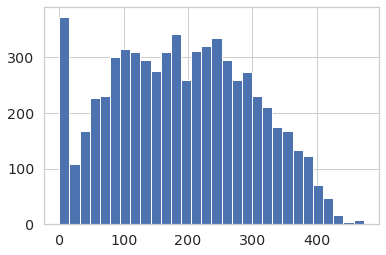

In [40]:
plt.hist(y_pred, bins=30);

In [41]:
df_submit = pd.DataFrame({'datetime':test['datetime'],'count':y_pred})
df_submit = df_submit[['datetime','count']]
df_submit.head(10)

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
5,2011-01-20 05:00:00,0
6,2011-01-20 06:00:00,0
7,2011-01-20 07:00:00,6
8,2011-01-20 08:00:00,14
9,2011-01-20 09:00:00,39


Why didn't we use feature selection for this problem?

In [42]:
print(f"The winning pipeline:\n {pipe}")

The winning pipeline:
 Pipeline(steps=[('scalar', StandardScaler()), ('estimator', Lasso(alpha=0.5))])


#### pipeline.named_steps
Get access to the internals of the pipeline using the following:

`pipe.named_steps.estimator.coef_`


In [43]:
# note that Lasso regularization zeroed out several of the features 
print(f"note that Lasso regularization zeroed out several of the features :\n{pipe.named_steps.estimator.coef_}")

note that Lasso regularization zeroed out several of the features :
[ -0.86851593   0.7986806   49.30631281  14.57379078 -37.02175395
   1.66579222  -0.           2.47906541  -8.54516982   0.18550432
  -0.           0.13640983 -18.61751468   0.          53.581956
   0.          27.22198062  39.3896986 ]


#  Core task: Boston House Prices (LR +  Regularization)

We have seen this dataset previously while working with Regression in module 04. In this notebook, we're going to build a  regression model with and without regularization for predicting house prices.

Import required libraries

In [44]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Build a regression model

Boston dataset is extremely common in machine learning experiments thus it is embedded in sklearn.

In [45]:
boston = load_boston()

Detailed description of dataset and features

In [46]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Create pandas dataframe with objects in rows and features in columns

In [47]:
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [48]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Split the training data into train and a blind test set using scikit's train_test_split package.

In [49]:
np.random.seed(42)

from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Normalize data in the range $(0,1)$ to make our data insensitive to the scale of features.

In [50]:
scaler = StandardScaler()

Note that we're going to learn normalization constants only on training set. That's done because the assumption is that test set is unreachable during training.

In [51]:
X_train = scaler.fit_transform(X_train)

Transform test set with the same constants

In [52]:
X_test = scaler.transform(X_test)

Here we use very simple Linear Regression model. Scikit-learn uses the closed-form solition for Linear Regression problem thus it gives very good results.

In [53]:
model_sk = LinearRegression()

Fitting model on prepared data

In [54]:
model_sk.fit(X_train, y_train)

LinearRegression()

Predicting both train and test sets to evaluate model

In [55]:
y_pred_test = model_sk.predict(X_test)
y_pred_train = model_sk.predict(X_train)

In [56]:
from sklearn.metrics import mean_squared_error, r2_score
#Root_Mean_Square Error(RMSE) is performance criteria for this problem
# errors on  count
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('RMSE test: %.3f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R2 train: %.3f' % r2_score(y_train, y_pred_train ))
print('R2 test: %.3f' % r2_score(y_test, y_pred_test))

RMSE train: 4.652
RMSE test: 4.929
R2 train: 0.751
R2 test: 0.669


## Build GridSearch pipeline to compare alpha combinations using Ridge and Lasso 

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

In [59]:
np.random.seed(42)

estimators = [('ridge', Ridge()),
              ('lasso', Lasso())]

best_score = []
best_param = []
for estimator in estimators:
    params = {estimator[0]+'__alpha':[.01, .05, .1, .5, 1, 5]}
    
    pipe = Pipeline([('scalar', StandardScaler()), estimator])
    gs = GridSearchCV(pipe, params, scoring='neg_mean_squared_error', cv=5)
    
    gs.fit(X_train, y_train)
    best_score.append(gs.best_score_)
    best_param.append(gs.best_params_)
    
best_idx = np.argmax(best_score)
print('Best model is:', estimators[best_idx][0], 'with parameter', best_param[best_idx])

Best model is: ridge with parameter {'ridge__alpha': 1}


## Generate predictions using best combination

In [60]:
#estimator = estimators[best_idx][0], list(best_param[best_idx].values())[0])
estimator = [Ridge, Lasso][best_idx]
param = list(best_param[best_idx].values())[0]
print (param)
# set up the pipeline using the best estimator
pipe = Pipeline([('scalar', StandardScaler()), ('estimator', estimator(alpha=param))])
pipe.fit(X_train, y_train)

1


Pipeline(steps=[('scalar', StandardScaler()), ('estimator', Ridge(alpha=1))])

In [61]:
y_pred_train = pipe.predict(X_train)

In [62]:
y_pred_test = pipe.predict(X_test)

In [63]:
from sklearn.metrics import mean_squared_error, r2_score
#Root_Mean_Square Error(RMSE) is performance criteria for this problem
# errors on  count
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('RMSE test: %.3f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R2 train: %.3f' % r2_score(y_train, y_pred_train ))
print('R2 test: %.3f' % r2_score(y_test, y_pred_test))

RMSE train: 4.652
RMSE test: 4.931
R2 train: 0.751
R2 test: 0.668


# Core Task: Diabetes Progression Regression (with pipeline-based derived features and feature selection)


This section provides all the data and code. Please run all cells in this section and  respond to the questions included here. Feel free to modify the code once you have completed the tasks, amd experiment with new settings.


## Introducing the problem dataset
Predict diabetes progression one year after baseline using patient information and tests such as:
*     Age
*     Sex
*     Body mass index
*     Average blood pressure
*     S1
*     S2
*     S3
*     S4
*     S5
*     S6


## Load the dataset

In [64]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

In [65]:
## 

In [66]:
diabetes = load_diabetes()
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

## Exploratory data analysis
Perform EDA through visualizing the data and also do other statistical analysis.

Note that we shift the X data to make it all positive.  It doesn't affect the results, but some of the subsequent algorithms only work with positive data

In [67]:
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names) 
y = diabetes.target
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [68]:
X.describe() # Let's also take a look into correlation matrix of features

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.639623e-16,1.309912e-16,-8.013951e-16,1.289818e-16,-9.042540e-17,1.301121e-16,-4.563971e-16,3.863174e-16,-3.848103e-16,-3.398488e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


Let's also take a look into correlation matrix of features

In [69]:
# compute the correlation matrix
X_y = pd.DataFrame(np.c_[diabetes.data, diabetes.target], columns = diabetes.feature_names + ["diabetesProg"])
# NOTE: np.c_[diabetes.data, diabetes.target] append vector to matrix 
corr = X_y.corr()
corr

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,diabetesProg
age,1.000000,0.173737,0.185085,0.335427,0.260061,0.219243,-0.075181,0.203841,0.270777,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241013,0.035277,0.142637,-0.379090,0.332115,0.149918,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395415,0.249777,0.261170,-0.366811,0.413807,0.446159,0.388680,0.586450
bp,0.335427,0.241013,0.395415,1.000000,0.242470,0.185558,-0.178761,0.257653,0.393478,0.390429,0.441484
s1,0.260061,0.035277,0.249777,0.242470,1.000000,0.896663,0.051519,0.542207,0.515501,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185558,0.896663,1.000000,-0.196455,0.659817,0.318353,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178761,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257653,0.542207,0.659817,-0.738493,1.000000,0.617857,0.417212,0.430453
s5,0.270777,0.149918,0.446159,0.393478,0.515501,0.318353,-0.398577,0.617857,1.000000,0.464670,0.565883
s6,0.301731,0.208133,0.388680,0.390429,0.325717,0.290600,-0.273697,0.417212,0.464670,1.000000,0.382483


### Compute the correlation matrix between all inputs and the output


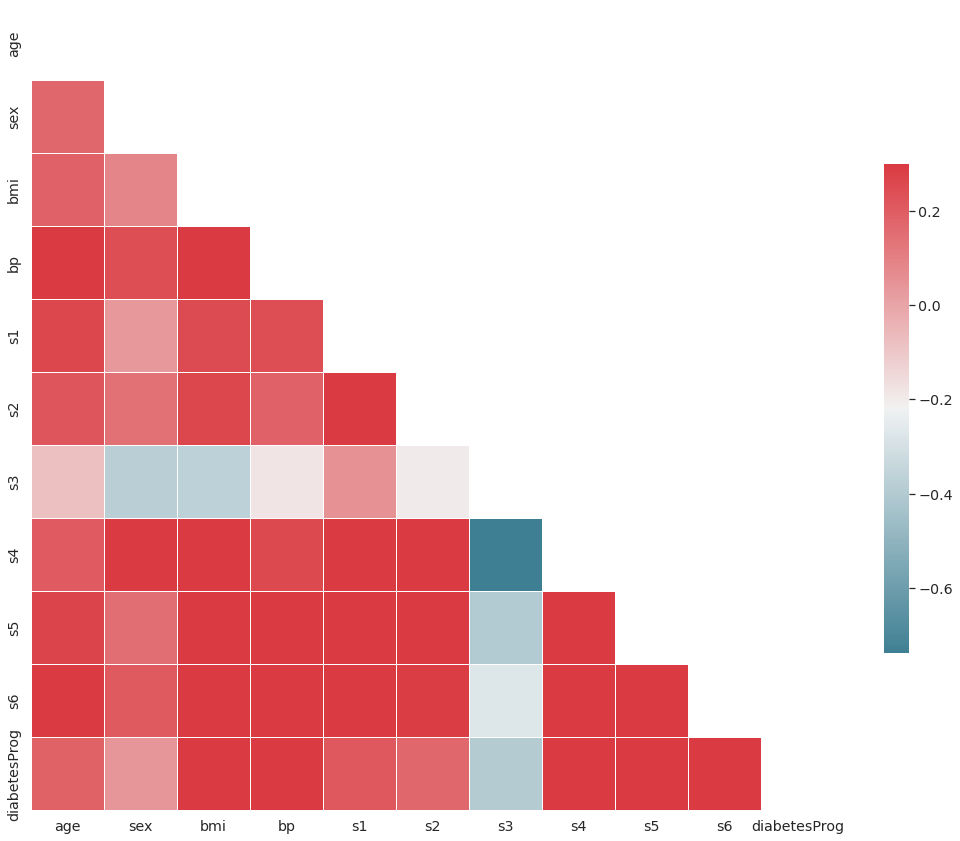

In [70]:
# compute the correlation matrix
X_y = pd.DataFrame(np.c_[diabetes.data, diabetes.target], columns = diabetes.feature_names + ["diabetesProg"])
# NOTE: np.c_[diabetes.data, diabetes.target] append vector to matrix 
corr = X_y.corr()

# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 11, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

### Visualize the data pairwise using the seaborn's `pairplot()`

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,diabetesProg
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


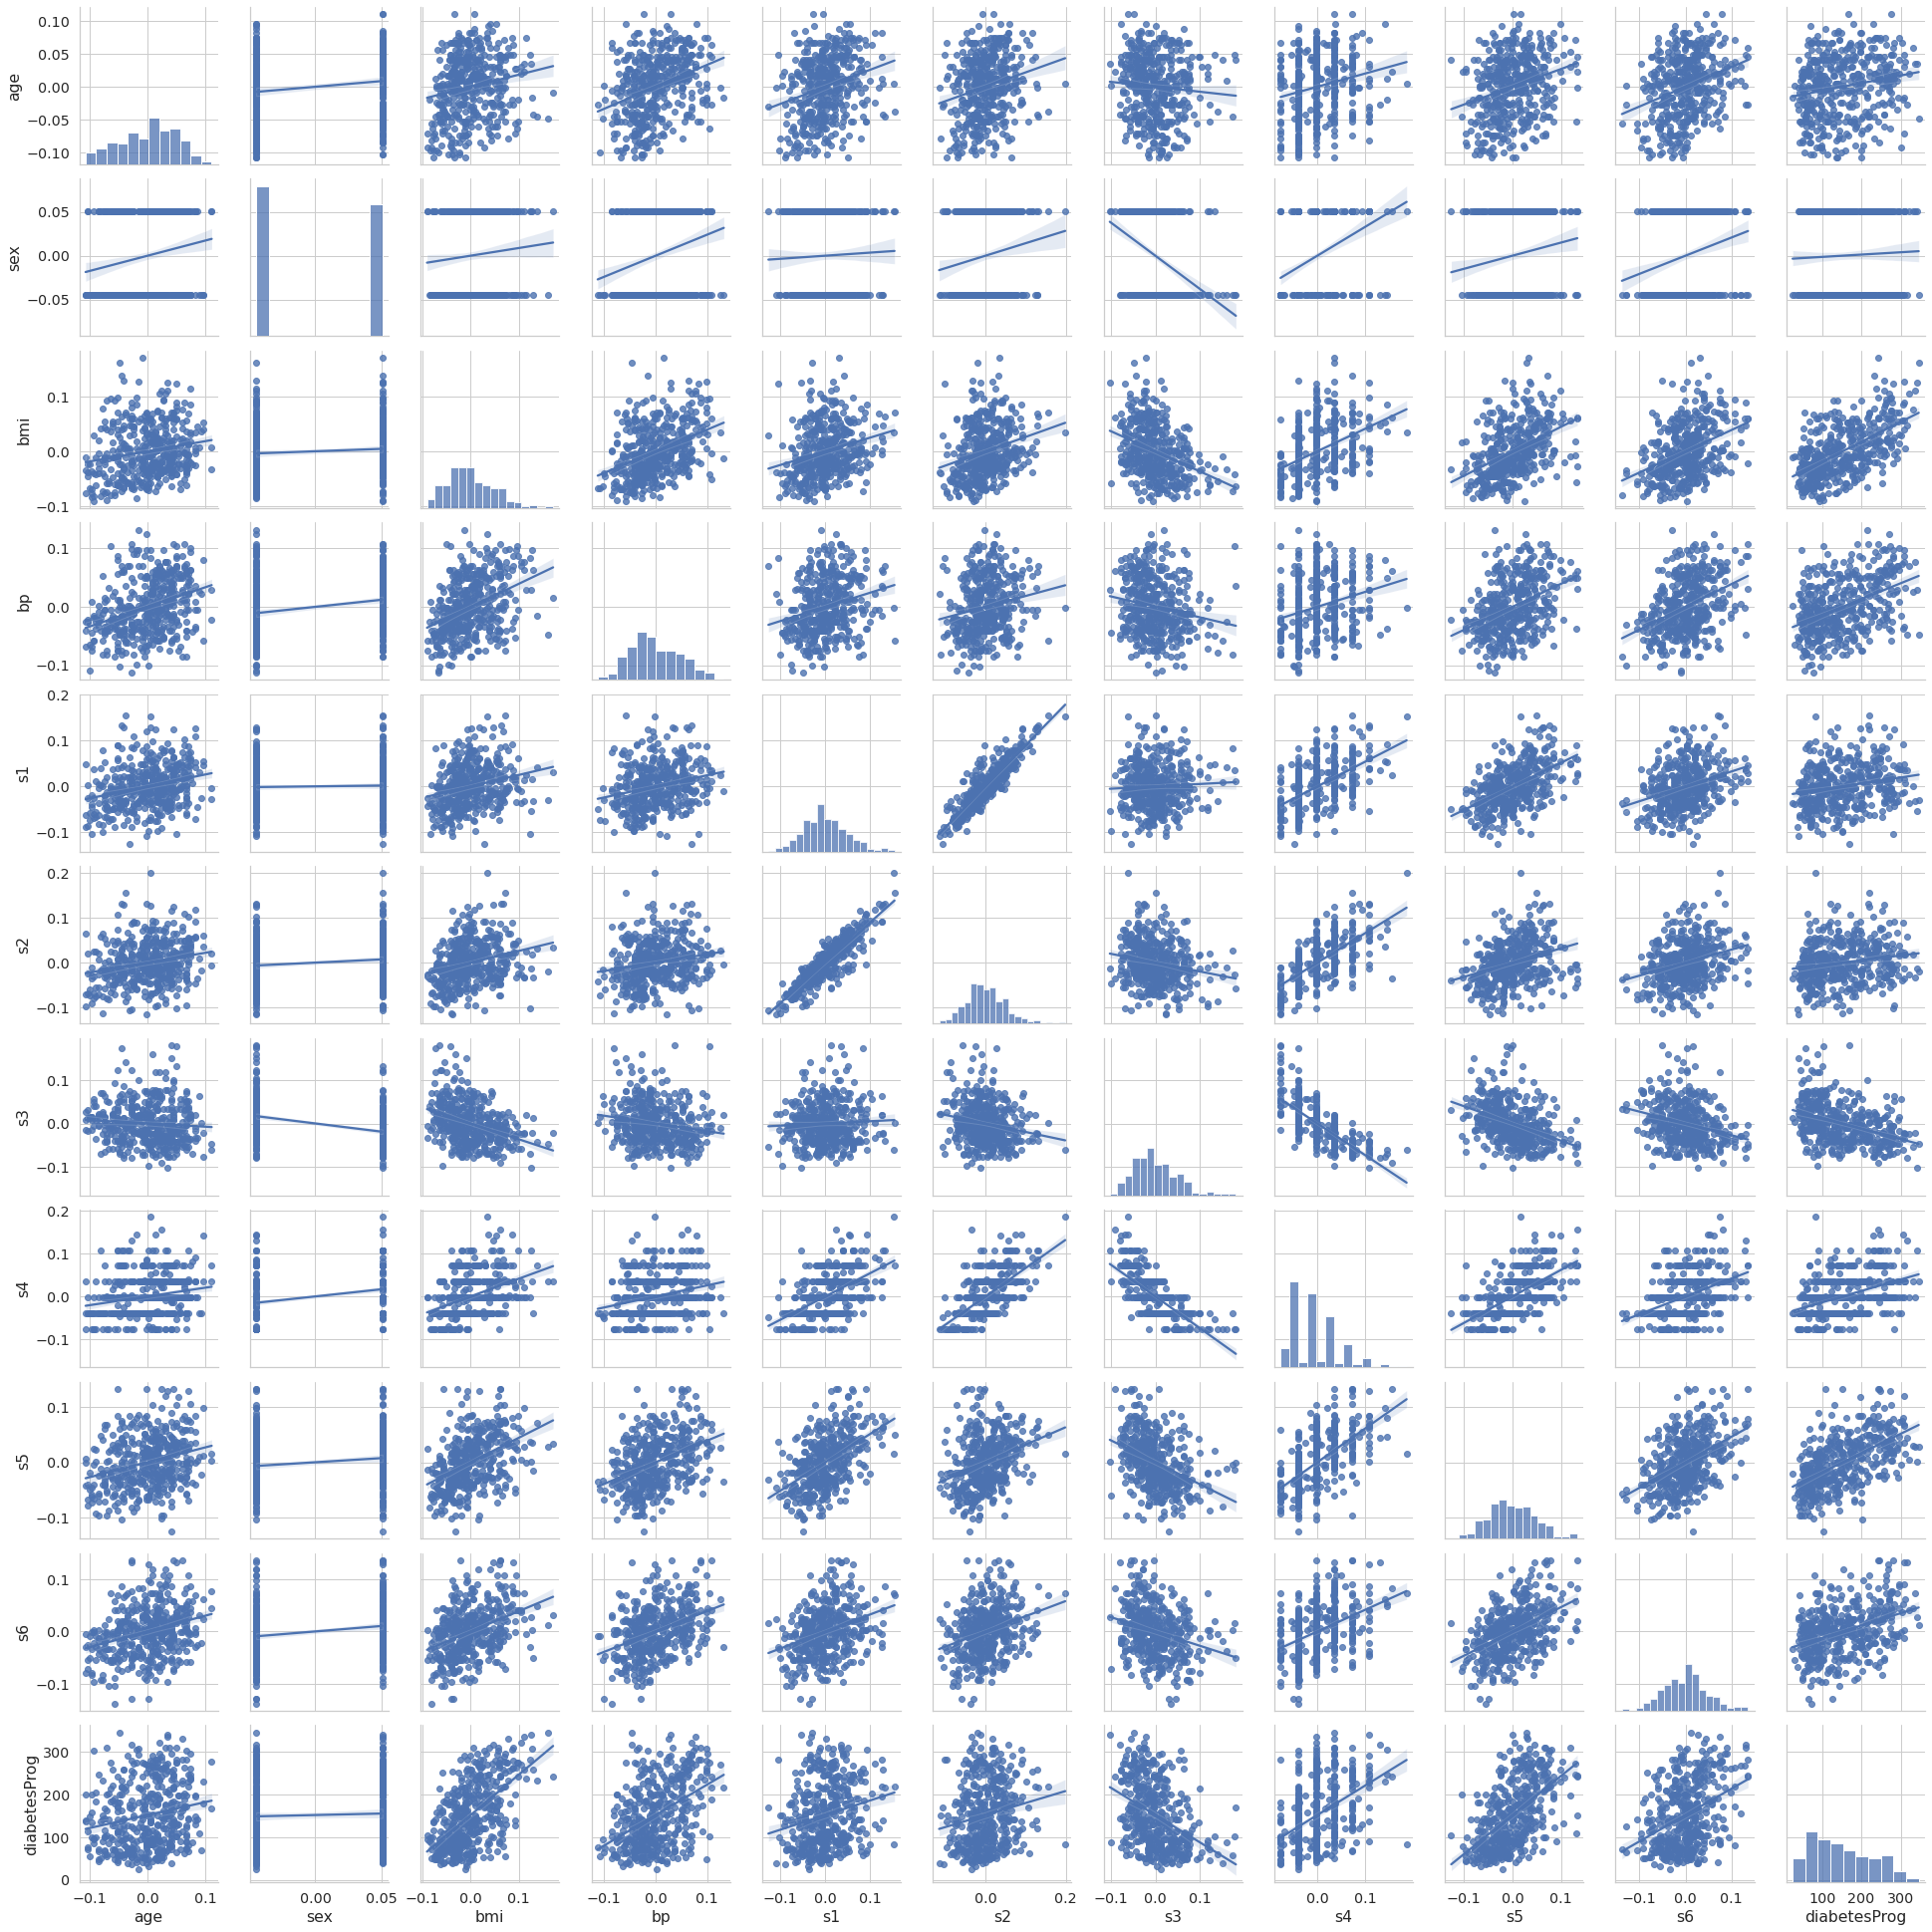

In [71]:
from sklearn import datasets
import numpy as np

diabetes = datasets.load_diabetes()
# iris = datasets.load_iris()
#X = iris.data[:, [2, 3]]
#y = iris.target
type(y)
diabetes_i_o_matrix = np.c_[diabetes.data, diabetes.target]  #append vector to matrix 
df = pd.DataFrame(diabetes_i_o_matrix, columns=diabetes.feature_names + ["diabetesProg"])
  
sns.pairplot(df, kind="reg")
df.head()

## Split data into Train and Test

Split data into 70% training and 30% test data. GridSearch uses crossfold validation. Therefore we do not need a validation set.

In [72]:
type(X)  #data stored in a numpy.ndarray

pandas.core.frame.DataFrame

In [73]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
import numpy as np

ds = datasets.load_diabetes()

X_train, X_test, y_train, y_test = train_test_split(
    ds.data, ds.target, test_size=0.3, random_state=1)

In [74]:
print(f'X_train.shape: {X_train.shape}  y_train: {len(y_test)}')
print(f'X_test.shape: {X_test.shape}  y_test: {len(y_test)}')


X_train.shape: (309, 10)  y_train: 133
X_test.shape: (133, 10)  y_test: 133


## Feature engineering

At this point we could do some feature engineering. For example, we could create a new `area` feature based upon taking the product of the length and width features if a problem had such features (e.g., see the iris flower classification problem). We would view this feature as a derived feature based upon the interaction of two base input features. 

Next we look at how to generate interaction features and polynomial features using SKLearn's `PolynomialFeatures()`.



### Polynomial and Interaction Features

Here we  explore datasets with polynomial features and interaction features.

First of all, we can generate such a dataset using sklearn, this code will demonstrate how to use it. (You can also use [this link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) to check the user guide)

```python
from sklearn.preprocessing import PolynomialFeatures
x = np.arange(4).reshape(2, 2)
poly = PolynomialFeatures(2)
print (x)
poly.fit_transform(x)

### outputs the following:
[[0 1]
 [2 3]]
array([[1., 0., 1., 0., 0., 1.],
       [1., 2., 3., 4., 6., 9.]])
```


Here using the original dataset of the form $(x_1,x_2)$ = [[0,1], [2,3]], in combination with `PolynomialFeatures(2)` yields a new dataset $(1,x_1,x_2,x_1^2,x_1x_2,x_2^2)$ = (1,0,1,0,0,1), (1,2,3,4,6,9)

## Train a ridge linear regression model using derived features

### The General Pipeline Interface
The Pipeline class is not restricted to preprocessing and classification, but can in
fact join any number of estimators together. For example, you could build a pipeline
containing feature extraction, feature selection, scaling, and classification, for a total
of four steps (at least!). Similarly, the last step could be regression or clustering instead of classification.

The only requirement for estimators in a pipeline is that all but the last step need to
have a transform method, so they can produce a new representation of the data that
can be used in the next step.
Internally, during the call to `Pipeline.fit()`, the pipeline calls fit and then transform
on each step in turn(or just `fit_transform()`), with the input given by the output of the transform method of the previous step. For the last step in the pipeline, just `fit()` is called.


#### Heatmap plotting helper function

In [75]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", title =""):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    ax.set_title(title)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img


### Grid-searching:  preprocessing, polyFeatures,  and modeling

In [76]:
from sklearn.datasets import load_diabetes
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectPercentile, f_regression


ds = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(ds.data, ds.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    PolynomialFeatures(),
    StandardScaler(),
    Ridge())

param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 
             }

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_absolute_error')

In [77]:
# multiply by -1 to convert utility to loss
# I.e., recover mean_absolute_error from 'neg_mean_absolute_error'
grid.cv_results_['mean_test_score'].reshape(3, -1)*[-1.0] 

array([[ 44.91738873,  44.91647662,  44.90770714,  44.84493389,
         44.74831585,  46.00356004],
       [ 48.46119478,  48.1859605 ,  47.82371022,  46.45813267,
         44.91168914,  45.65990836],
       [265.66721069, 176.00935899, 120.51317976,  77.00289633,
         53.78820913,  47.23253223]])

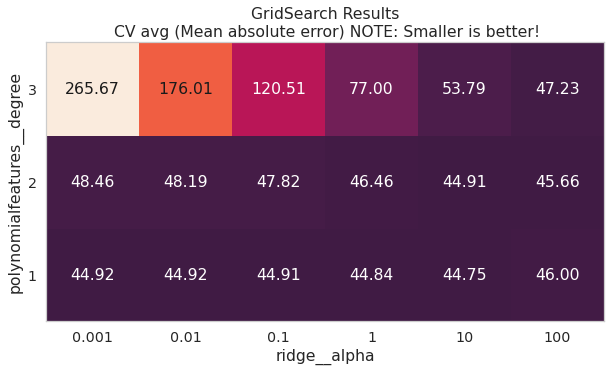

In [78]:
ax = plt.subplots(figsize=(10,10))
heatmap(-grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0,
       title="GridSearch Results\n CV avg (Mean absolute error) NOTE: Smaller is better!")


In [79]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 1, 'ridge__alpha': 10}


In [80]:
# score returns neg_mean_absolute_error so must muiltiply by -1.0 to 
# get the loss metric: mean_absolute_error
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test) *-1.0)) 

Test-set score: 45.15


### Question: polynomial features

Do the polynomial features help with to the test error? 

### Question: mean_absolute_error

What is the mean absolute error on the test dataset for this pipeline? Report to two decimal places.

### Simple pipeline with original features only
Just crosschecking the pipeline with original features only

In [81]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)
print("Test-score without poly features: {:.2f}".format(-grid.score(X_test, y_test)))

Test-score without poly features: 45.15


## Pipeline-based derived features and feature selection

In [86]:
from sklearn.datasets import load_diabetes
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectPercentile, f_regression, SelectKBest

ds = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(ds.data, ds.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    SelectPercentile(score_func=f_regression),
    Ridge())

param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 
              'selectpercentile__percentile' : [10,20,50, 65, 70,80,90]
             }

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
#grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)
print("Best parameters: {}".format(grid.best_params_))
print("Test-set score: {:.2f}".format(-grid.score(X_test, y_test)))
#grid.estimator.named_steps.selectkbest.get_support(indices=True) #does not work as expected. Bug?


Best parameters: {'polynomialfeatures__degree': 1, 'ridge__alpha': 10, 'selectpercentile__percentile': 65}
Test-set score: -0.33


### Question: number of features
Use selectpercentile for feature selection, what is the best percentile using this pipeline?

### Question: mean_absolute_error
What is the mean absolute error on the test dataset for this pipeline? Report to two decimal places.



# Core Task: Linear Regression with custom dataset

## Load Data

Consider the provided dataset "1.csv". The datas contains 5 columns, $x_1, x_2, x_3, x_4$, and $y$. We know that the datas were generated by the following function $y=\sum_{i=1}^4 w_i x_i+b$, where $w_1, \ldots, w_4,b$ are constants. However, we do not know the coefficients, and the datas are noisy. Let us implement linear regression to find out $w_1, \ldots, w_4,b$.

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('1.csv')
x = data.values[:,0:4]
y = data.values[:,4]
print(np.shape(x))
print(np.shape(y))
data.describe()

## Data Augmentation

Then, we implement data augmentation as shown in video 4.5 and solve for the closed-form solution for linear regression

In [ ]:
#Data augmentation
X = np.c_[np.ones(x.shape[0]), x]
print(np.shape(X))

## Linear Regression

### Implement Closed-Form Solution

In [ ]:
#Closed-form solution (Hint: You can use np.matmul for matrix multiplication)
#==================================================#
#               Place your code between here       #
  
w = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.transpose(),X)),X.transpose()),y) #change this one line only
#               ... and here                       #
# When asked to copy/paste your code in homework   # 
# submission quiz, only submit the code you added  #
# (or modified) between the comment blocks         #
# Hint:  you need to set the params used below     #
#==================================================#
print("Linear regrssion model (note weight_0 represents the bias term)")
for i, w_v in enumerate(w):
    print (f"weight_{i}: {w_v:.3f}")

#### Question: what is the value of bias term? Please report up to 3 decimal places.


### Calculate MSE

In [ ]:
#Calculate Mean-Squared Error
#==================================================#
#               Place your code between here       #

yhat = X.dot(w)
MSE = np.sum((y-yhat)**2)/np.shape(y)[0]
# When asked to copy/paste your code in homework   # 
# submission quiz, only submit the code you added  #
# (or modified) between the comment blocks         #
# Hint:  you need to set the params used below     #
#==================================================#
print (f"MSE:  {MSE:.3f}")

#### Question: what is MSE for this given dataset? Please report up to 3 decimal places.




### Using SKlearn

Let's try the linear regression tool from sklearn, is the solution similar to yours?

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False).fit(X, y)
#reg.coef_
print("Linear regrssion model (note weight_0 represents the bias term)")
for i, w_v in enumerate(reg.coef_):
    print (f"weight_{i}: {w_v:.3f}")

Here we can see that the original function could be $y=3x_1+x_4+2$

## Polynomial and Interaction Features

Part1 of this questions shows a linear relation between the inputs and the outputs. However this is usually not the case for real-life applications. In this part, we will explore datasets with polynomial features and interaction features.

First of all, we can generate such a dataset using sklearn, this code will demonstrate how to use it. (You can also use [this link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) to check the user guide)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
x = np.arange(4).reshape(2, 2)
poly = PolynomialFeatures(2)
print (x)
poly.fit_transform(x)

Here the original dataset is $(x_1,x_2)$ = (0,1), (2,3),
and we generated a new dataset $(1,x_1,x_2,x_1^2,x_1x_2,x_2^2)$ = (1,0,1,0,0,1), (1,2,3,4,6,9)

## Load the Second Dataset

Now consider a dataset "2.csv" similar to part1, generated by the function $y=\sum_{i=1}^3 w_i x_i+\sum_{i=1}^3 v_i x_i^2+\sum_{i,j=1(i\ne j)}^3 u_{ij} x_i x_j + b$.

In [ ]:
#load the new dataset
data = pd.read_csv('2.csv')
x = data.values[:,0:3]
y = data.values[:,3]
print(np.shape(x))
print(np.shape(y))
data.describe()

## Polynomial Regression

Is this new function solvable by linear regression? The answer is yes. The only thing we have to do is to generate polynomial and interaction features.

In [ ]:
X = poly.fit_transform(x)
print (np.shape(X))

In [ ]:
reg = LinearRegression(fit_intercept=False).fit(X, y)
reg.coef_

Now, we know these are the coefficients of the original function, let's see if we can recover them from all the derived features (interactions and polynomials). Run the following code and respond to the questions following the code.

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectPercentile, f_regression, SelectKBest
from sklearn.model_selection import train_test_split

#ds = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
#==================================================#
#               Place your code between here       #
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    SelectPercentile(score_func=f_regression),  #Percent of features to keep.
    #SelectKBest(score_func=f_regression),
    Ridge())

param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 
              'selectpercentile__percentile' : [10,20,50,65,70,80,90]
             }
#               ... and here                       #
# When asked to copy/paste your code in homework   # 
# submission quiz, only submit the code you added  #
# (or modified) between the comment blocks         #
# Hints:  
# 1. The pipeline should contain:
#    StandardScaler, SelectPercentile with f_regression
#    as the scoring function parameter, PolynomialFeatures,
#    and Ridge
# 2. SelectPercentile  percentile parameter should have
#   following options: 10,20,50,65,70,80,90
#==================================================#
# Replace with:
# pipe = make_pipeline(
#       ...)
# 
# param_grid = {'polynomialfeatures__degree': [1, 2, 3],
#               'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 
#               'selectpercentile__percentile' : ...
#               ...
#              }

#grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)
print("Best parameters: {}".format(grid.best_params_))
print("Test-set score: {:.5f}".format(-grid.score(X_test, y_test)))
#grid.estimator.named_steps.selectkbest.get_support(indices=True) #does not work as expected. Bug?


### Understanding this model

Ok, so we just used grid search to search for the best model/parameter combination for this model. Let's take a look and understand what it means.

First, let's see what is inside this pipeline.

In [ ]:
print (grid.best_estimator_)

poly = grid.best_estimator_.named_steps['polynomialfeatures']
select = grid.best_estimator_.named_steps['selectpercentile']
ridge = grid.best_estimator_.named_steps['ridge']

In [ ]:
import numpy as np 
print (np.shape(X_train))
X_train_poly = poly.fit_transform(X_train)
print (np.shape(X_train_poly))

In [ ]:
X_train_poly_selected = select.fit_transform(X_train_poly,y_train)
print (np.shape(X_train_poly_selected))
#Here we are selecting 90% top features, so only 8 features remaining.

### Order of Coefficients

To figure out which feature was dropped, we print out the order of coefficient, then look at the p_values of feature selection step.

In [ ]:
feature_names = features = poly.get_feature_names()
print(f"all features before selection: \n{feature_names}")

#p_values = select.pvalues_
#print ("{p_values:}")

feature_names_selected = [feature_names[k]  for k in select.get_support(indices=True)]

print(f"{feature_names_selected}\n{len(feature_names_selected)} features of {len(feature_names)} were selected ")
print("NOTE: the bias feature was dropped temporarily")
print(f"The following features were dropped{set(feature_names) - set(feature_names_selected)}")

In [ ]:
np.round(34.4415556, 2)

In [ ]:
print("The Linear regressions model is as follows:")
print(f"{dict(zip(feature_names_selected, np.r_[ridge.intercept_, ridge.coef_]))}")
print("The polynomial regression model is a follows:")

display(pd.DataFrame(np.expand_dims(np.round(np.r_[ridge.intercept_, ridge.coef_], 3), axis =0), columns=["BIAS"]+feature_names_selected))

### Does the pipeline identify select the raw features only?  Yes or no?


### Question: what is the coefficient for the term $x_1x_2$? 
What is the coefficient for the term $x_1x_2$? Report with 3 decimal point precision.  Example: 5.139 is reported for  5.1387462123

# Predicting baseball player salaries using Lasso Linear Regression

In machine learning, LASSO (least absolute shrinkage and selection operator) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the resulting statistical model. Lasso can be formulated for linear regression models (linear classification models: we will discuss this in a later module) as follows: 


$$
J(\boldsymbol{\theta}) = \overbrace{ \text{MSE}(\boldsymbol{\theta})}^{\text{Hard Data Loss Term}} + \alpha \overbrace{\sum\limits_{i=1}^{n}\left| \theta_i \right|}^{\text{L1-based regularization term}}
$$

Lasso regression performs L1 regularization, which adds a penalty equal to the absolute value of the magnitude of coefficients. This type of regularization can result in sparse models with few coefficients; Some coefficients can become zero and eliminated from the model. Larger penalties result in coefficient values closer to zero, which is the ideal for producing simpler models. On the other hand, L2 regularization (e.g. Ridge regression) doesn’t result in elimination of coefficients or sparse models. This makes the Lasso far easier to interpret than the Ridge. 

A tuning parameter, $\alpha$ controls the strength of the L1 penalty. $\alpha$ is basically the amount of shrinkage:

* When $\alpha$ = 0, no parameters are eliminated. The estimate is equal to the one found with linear regression.
* As $\alpha$ increases, more and more coefficients are set to zero and eliminated (theoretically, when $\alpha$ = ∞, all coefficients are eliminated).
* As $\alpha$ increases, bias increases.
* As $\alpha$ decreases, variance increases.

Obviously, we first need to tune $\alpha$ hyperparameter in order to have the right kind of Lasso regression.

Note the bias term  is included in the regularization term.

The gradient for Lasso loss function is discontinuous about zero and results in following subgradient:

**Lasso Regression subgradient vector**

$$
\nabla_{\mathbf{\theta}}\, \text{LassoMSE}(\mathbf{\theta}) = \nabla_{\boldsymbol{\theta}}\, \text{MSE}(\boldsymbol{\theta}) +  \alpha
\begin{pmatrix}
  0 \\
  \operatorname{sign}(\theta_1) \\
  \operatorname{sign}(\theta_2) \\
  \vdots \\
  \operatorname{sign}(\theta_n) \\
\end{pmatrix} \quad \text{where } \operatorname{sign}(\theta_i) =
\begin{cases}
-1 & \text{if } \theta_i < 0 \\
0 & \text{if } \theta_i = 0 \\
+1 & \text{if } \theta_i > 0
\end{cases}
$$

For more background on Lasso see the following:

* [An Introduction to Statistical Learning](https://www.statlearning.com/) by James et al. (2021), 
* and the [scikit-learn documentation about regressors with variable selection](https://scikit-learn.org/stable/modules/classes.html#regressors-with-variable-selection)

## Baseball Hitters Dataset

The objective here is to predict the salaries of baseball players based upon their track record on the field. This dataset consists of Major League Baseball Data from the 1986 and 1987 seasons. 

    AtBat: Number of times at bat in 1986
    Hits: Number of hits in 1986
    HmRun: Number of home runs in 1986
    Runs: Number of runs in 1986
    RBI: Number of runs batted in in 1986
    Walks: Number of walks in 1986
    Years: Number of years in the major leagues
    CAtBat: Number of times at bat during the hitters' career
    CHits: Number of hits during the hitters' career
    CHmRun: Number of home runs during the hitters' career
    CRuns: Number of runs during the hitters' career
    CRBI: Number of runs batted in during the hitters' career
    CWalks: Number of walks during the hitters' career
    League: A factor with levels A and N indicating player's league at the end of 1986 
    (A: American League, N: National League)
    Division: A factor with levels E and W indicating player's division at the end of 1986
    (E: East Division, W: West Division)
    PutOuts: Number of put outs in 1986
    Assists: Number of assists in 1986
    Errors: Number of errors in 1986
    Salary: 1987 annual salary on opening day in thousands of dollars
    NewLeague: A factor with levels A and N indicating player's league at the beginning of 1987

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

## Importing the dataset

In [ ]:
# Fetch the dataset from the below link and convert it into a DataFrame df.
df = pd.read_csv("https://raw.githubusercontent.com/kirenz/datasets/master/Hitters.csv")

In [ ]:
df

### DataFrame info including the index dtype and columns, non-null values and memory usage.

In [ ]:
df.info()

### Checking for null values in the dataset

In [ ]:
print(df.isnull().sum())

We can observe that certain players' salary information is missing from the dataset. There might be a variety of causes for this, including poor performance by players, elimination from the league, or just a collection of noisy data points. As a result, we discard all null values in the following cells to ensure data consistency.

#### Dropping Null Values from the dataset

In [ ]:
## Dropping rows with NAN using dropna in order to clean our data for more accurate results
df = df.dropna()

## Convert categorical variable into dummy/indicator variables. 

As we can see, columns 'League', 'Division' and 'NewLeague' consists of catergorical values. 
A categorical variable is a variable that can take on one of a limited, and usually fixed, number of possible values, assigning each individual or other unit of observation to a particular group or nominal category on the basis of some qualitative property.

In this scenario, League and NewLeague have two category values: A and N, where A and N refer to the American and National Leagues, respectively. Similarly, we have two categorical values for Division: E and W, where E denotes the East Division and W denotes the West Division.

As we all know, categorical variables can't be used in any form of model-based prediction, thus to avoid them, we use One Hot Encoding to hot encode them into numerical values.

We use **pandas.get_dummies()** to convert categorical varibales into dummy/ indicator variables.

In [ ]:
## Passing the categorical features from the dataset to get the dummy variables.
dummies = pd.get_dummies(df[['League', 'Division','NewLeague']])

In [ ]:
dummies.info()

In [ ]:
dummies.head()

### Dropping the Target and Categorical features from the dataset 

To construct a new data frame with solely numerical characteristics, we remove our target feature 'Salary' and categorical features 'League', 'Division', and 'NewLeague' from our dataset.

In [ ]:
## Storing the Target column 'Salary'
y = df['Salary']

In [ ]:
## Dropping all the categorical and target columns
X_numerical = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

In [ ]:
# list_numerical will comprise of only the numerical features
list_numerical = X_numerical.columns
list_numerical

### Concatenating newly created dummy numerical features

We merge our categorical features withe the newly created dummy numerical features so as to restore our dataset to it's original form but now only including numerical values for all the features.

In [ ]:
# Concatinating newly created dummy numerical features
x_raw_numerical_feats = np.arange(X_numerical.shape[1])

#since all features are binary we only need to introduce one version of the variable
X = pd.concat([X_numerical, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

features = X.columns

### Save (aka checkpoint) preprocessed (NA removed, dummy vars) data to file

In [ ]:
X_y = pd.concat([X, y], axis=1)
X_y.to_csv('X_y.csv',index=False)

## Coefficient shrinkage (to zero) via Lasso regression 
Lasso regression has one hyperparameter, $\alpha$, the mixing weight associating the L1 regularization term in the Lasso objective function. We first illustrate Lasso in operation for $\alpha=1$.


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# load preprocessed data
X_y = pd.read_csv('X_y.csv')

# Splitting X_y into target and other varibales
y = X_y['Salary']
X = X_y.drop(['Salary'], axis=1).astype('float64')

# Splitting the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# scale  the data 
scaler = StandardScaler().fit(X_train[list_numerical]) 
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

To better understand the role of alpha, we run experiments on learning a linear regression model via minimizing the Lasso objective function for different levels of $\alpha$. Then plot the lasso coefficients as a function of alpha (max_iter are the maximum number of iterations of gradient descent). 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

alphas = np.arange(0.01,50,0.1)
lasso = Lasso(max_iter=10000)
coefs = []
coefs_dict = {}
R_square = []
importance_count = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    coefs_dict[a]=lasso.coef_
    importance_count.append(sum(np.abs(lasso.coef_)!=0))
    R_square.append(round(lasso.score(X_train, y_train)*100, 2))

plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.legend(X.columns,loc='center left', bbox_to_anchor=(1.1, 0.5))

ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha in Lasso-based learning')
plt.grid()
plt.show()


plt.figure(figsize = (8,8))
ax1 = plt.gca()

ax1.plot(alphas, coefs)
ax1.legend(X.columns,loc='center left', bbox_to_anchor=(1.1, 0.5))
ax1.set_xscale('log')
ax1.set_ylabel('Standardized Coefficients')
ax1.set_xlabel('alpha')

ax2 =  ax1.twinx()
ax2.plot(alphas, importance_count,'r--', label = '# of selected variables',linewidth=4)
ax2.legend()
ax2.set_ylim([0,18])
ax2.set_ylabel('# of selected variables')


plt.axis('tight')
plt.title('Lasso coefficients as a function of alpha')
plt.grid()
plt.show()

The plot given above describes the relation between the Lasso Coefficients and the mixing coefficient alpha for Lasso Regression.

The plotted lines represent every single feature from the Hitters dataset and how they vary with resepect to increasing alpha value.

From the above plot, by observing the standardized lasso coefficients as a function of $\alpha$ and Lasso Regression formula, it can be inferred that higher the $\alpha$, more penalty is applied to the coefficients, and the coefficients tend to reach zero at very high $\alpha$ values (more than 100).



### Task: Complete the code and report the number of features discarded by the model i.e features with zero importance for alpha = 10.01
Hint: The coefficients of the features are stored in coefs_dict

In [ ]:
##TODO: complete the code
sum(np.abs(coefs_dict[10.01]) == 0)

## Optimizing the Lasso hyperparameter $\alpha$ via gridsearch and pipelines

To find the optimal value of alpha,we use a combination gridsearch (with crossfold validation and pipelines. Since our dataset needs to be scaled, to avoid [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)), we use a pipeline to perfrom gridsearch. The pipeline first standardizes all features on the training folds (obtained from  splitting training data into training and evaluation folds). We obtain all necessary statistics for our features (mean and standard deviation) from training data folds involved; then we the same stats to standardize the  evaluation fold. 



In [ ]:
lr_pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso(max_iter=10000))
])

This task focussed on optimising the α hyperparameter in the Lasso objective function for learning a linear regression model. Please explore the following values of α  0.001, 0.01, 1, 10, 100. For each value, we calculate the average value of the mean squared error in cross-validation and select the value of α that minimizes such average performance metrics. 

Note, for GridSearchCV please use `neg_mean_squared_error` because the grid search tries to maximize utility-based performance metrics. To convert a mean squared error loss into a utility, just multiply it by `-1` which leads to  `neg_mean_squared_error`. While the Lasso loss function is minimized to learn a linear regression model (as part of the inner loop of machine learning), a utility function based upon MSE only (think of MSE as a proxy for reality) is used in decision-making during the grod search (this utility is calculated as part of the cross fold validation step). This can be visualized as follows:



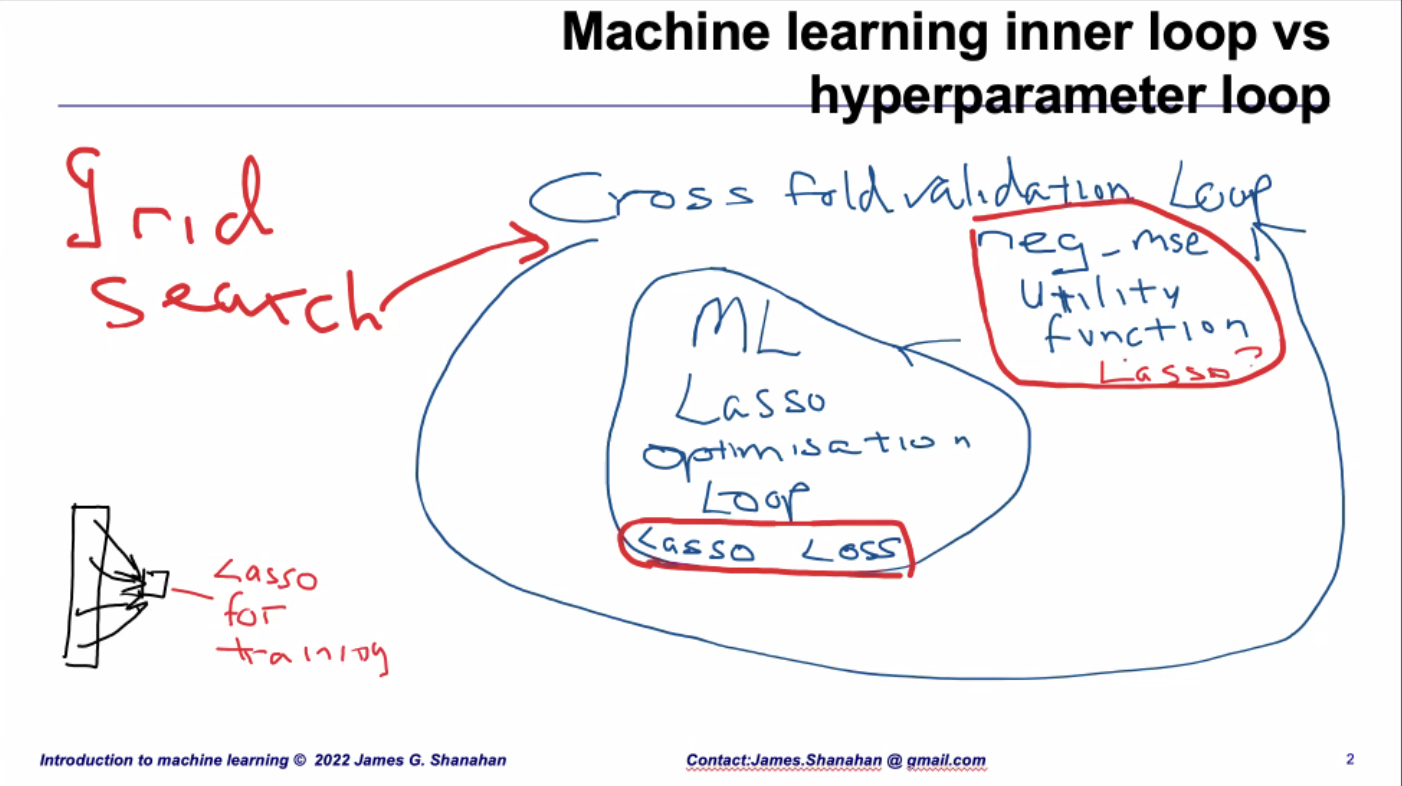




### TASK: Complete the gridsearch pipeline to determine the optimal α hyperparameter in  Lasso regression
Complete the following gridsearch pipeline to determine the optimal α hyperparameter in  Lasso regression.

In [ ]:
#the grid search will lead to the best regression pipeline

# Load preprocessed data
X_y = pd.read_csv('X_y.csv')

# Splitting X_y into target and other varibales
y = X_y['Salary']
X = X_y.drop(['Salary'], axis=1).astype('float64')

# Splitting the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr_pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso(max_iter=10000))
])
#==================================================#
#               Place your code between here       #

params = {'model__alpha':[0.001,0.01,1,10,100]}
lr_gridsearch = GridSearchCV(lr_pipeline, params,
                      cv = 5, scoring="neg_mean_squared_error",verbose=3)

# When asked to copy/paste your code in homework   # 
# submission quiz, only submit the code you added  #
# (or modified) between the comment blocks         #
# TODO: complete code above to
# params = {...} # aplha:[0.001,0.01,1,10,100]
# lr_gridsearch = GridSearchCV...
# Hint: Use 5-fold cross validation ,scoring metric as neg_mean_squared_error and verbose = 3
#==================================================#


In [ ]:
## Fitting our model using GridSearchCV
lr_gridsearch.fit(X_train,y_train)

### Checking for best $\alpha$ value
The best value for $\alpha$ can be evaluated in the following way:

In [ ]:
## Finding the best model__alpha value
lr_gridsearch.best_params_

### Getting coefficient values for the Lasso Regression from our model
Now, we have to get the values of the coefficients of the best estimator from our GridSearch of Lasso regression

In [ ]:
## Getting Lasso coefficient values
coefficients = lr_gridsearch.best_estimator_.named_steps['model'].coef_

### Denoting Feature Importances for the coeffiecients
The importance of a feature is the absolute value of its coefficient, so:

In [ ]:
## Feature importances
importance = np.abs(coefficients)
pd.DataFrame({"Varible":X.columns, "importance": importance})

As we can see, there are 8 features with 0 importance. These features have been discarded by our model.

The features that survived the Lasso regression are:

In [ ]:
np.array(features)[importance > 0]

While the 8 discarded features are:

In [ ]:
np.array(features)[importance == 0]

Thus, we can conclude that for best value of $\alpha$ which is 10, we get 8 features removed: AtBat ,Runs ,RBI ,Years ,CAtBat ,CHits ,CWalks ,Assists.

# Linear Regression via GD from scratch

The objective function of linear regression is the following:
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2,
n = \left|X_{\text{train}}\right|
$$
So we want to minimize the **squared value** of difference between predictions and real answers. It is called Mean Squared Error (MSE). Gradient Descent is the way of optimizing this complex functional and tune weigths $\mathbf{w}$ and bias $b$.

To be able to treat weigths $\mathbf{w}$ and bias $b$ homogeneously we're going to augment the data with the "shell" feature (all $1$'s). Then we can add one more parameter to the weight vector and treat it as a *bias*.

$$
\mathbf{x}' :=
\begin{bmatrix}
\mathbf{x}\\
1
\end{bmatrix},\quad
\boldsymbol{\theta} :=
\begin{bmatrix}
\mathbf{w}\\
b
\end{bmatrix}
$$
$$
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2
$$

In this way it is much more easier to carry out oprimization process.

To simplify it further and do it in "*tensor*" way let's rewrite it in matrix form. Let's introduce data matrix (the same as dataframe we used everywhere above)

$$
\text{X}' =
\begin{bmatrix}
\mathbf{x'}_1^{\text{T}}\\
\vdots\\
\mathbf{x'}_n^{\text{T}}
\end{bmatrix},\quad
\mathbf{y} = 
\begin{bmatrix}
y_1\\
\vdots\\
y_n
\end{bmatrix}
$$

Matrix $\text{X}$ contains objects in its rows and features in its columns. Vector $\mathbf{y}$ is a vector of answers. Then the objective can be rewritten as follows:

$$
f(\boldsymbol{\theta}) = \frac{1}{n}\|\text{X}'\cdot \boldsymbol{\theta} - \mathbf{y}\|_2^2
$$

Then the gradient can be easily calculated in vectorized form:

$$
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\text{X}'^{\text{T}}\left(\text{X}'\cdot \boldsymbol{\theta} - \mathbf{y}\right)
$$

Exactly this computations are implemented down below in **BasicLinearRegressionHomegrown** class

## Data

Split into train and test set (with the same $\text{random_state}$ which means we can compare results)

In [ ]:
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [ ]:
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaling

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Basic version of homegrown Linear Regression

In [ ]:
class BasicLinearRegressionHomegrown(object):
    
    def __init__(self):
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.history = {"cost": [], 
                        "coef": [], 
                        "intercept": [], 
                        "grad": []}
        
    def _grad(self, X, y):
        """
        Calculate the gradient of the objective function

        Args:
            X(ndarray):        train objects
            y(ndarray):        answers for train objects
        Return:
            gradient(ndarray): analytical gradient vector
        """
        pred = np.dot(X, self._theta)
        error = pred - y
        gradient = 2 * np.dot(error, X) / X.shape[0]
        return gradient
    
    # full gradient descent, i.e., not stochastic gd
    def _gd(self, X, y, max_iter, alpha=0.0005):
        """
        Runs GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            # calculate gradient
            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            # do gradient step
            self._theta -= alpha * grad
    
    def fit(self, X, y, max_iter=1000):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
        Return:
            self
        """
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously 
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        # initialize if the first step
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])
        
        # do full gradient descent
        self._gd(X, y, max_iter)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self
        
    def score(self, X, y):
        """
        Calculate RMSE metric

        Args:
            X(ndarray):      objects
            y(ndarray):      answers
        Return:
            rmse(float):     RMSE
        """
        pred = self.predict(X)
        error = pred - y
        rmse = (np.sum(error ** 2) / X.shape[0]) ** 0.5
        return rmse
        
    def predict(self, X):
        """
        Make a prediction

        Args:
            X(ndarray):      objects
        Return:
            pred(ndarray):   predictions
        """
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            pred = np.dot(X, self._theta)
        else:
            pred = np.dot(X, self.coef_) + self.intercept_
        return pred

Create model

In [ ]:
model_homegrown = BasicLinearRegressionHomegrown()

## Fitting

In [ ]:
model_homegrown.fit(X_train, y_train, max_iter=40000)

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(model_homegrown.history["cost"], label="Train")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Linear Regression via Gradient Descent")
plt.legend();

## Evaluation

In [ ]:
models = [model_sk, model_homegrown]
models_names = ["Sklearn", "Homegrown"]

In [ ]:
samples = [(X_train, y_train), 
           (X_test, y_test)]
models_names = ["Sklearn"]
models = [model_sk]

In [ ]:
evaluate(models, metrics, samples, metrics_names, models_names)

# Optional Assignment: Calculate the gradient numerically
The `BasicLinearRegressionHomegrown` class given above provides you with the  `_grad()` method that enables one to compute  gradient analytically. Typically the gradient is denoted as vector of partial derivatives:

\begin{matrix}
\nabla f(\mathbf{x}) =
[\frac{\partial f}{\partial x_1}
\vdots
\frac{\partial f}{\partial x_n}]\\
 \text{ where } n \text{ is the number of decision variables}
\end{matrix}


The numerical gradient of a function is a way to estimate the values of the partial derivatives in each dimension using the known values of the function at certain points:

\begin{matrix}
\text{ and }\frac{\partial f}{\partial x_1} = \lim_{\alpha \rightarrow 0} \frac{f(x_1 + \alpha, x_2 \ldots x_m) - f(x_1, x_2 \ldots x_m)}{\alpha}
\end{matrix}


For sufficiently small $\alpha$ one can approximate partial derivative by simple throwing out the limit operator

$$
\frac{\partial f}{\partial x_1} \approx \frac{f(x_1 + \alpha, x_2 \ldots x_n) - f(x_1, x_2 \ldots x_n)}{\alpha} = \left( \frac{\partial f}{\partial x_1} \right)_{\text{num}}
$$

Then the final approximation of the gradient is:

$$
\nabla f(\mathbf{x}) \approx \nabla_{\text{num}\,\,} f(\mathbf{x}) = \begin{bmatrix}
\left( \frac{\partial f}{\partial x_1} \right)_{\text{num}}\\
\vdots\\
\left( \frac{\partial f}{\partial x_n} \right)_{\text{num}}
\end{bmatrix}
$$

The common way of measuring the difference between vectors is the following:
$$
\text{er} = \frac{\|\nabla f(\mathbf{x}) - \nabla_{\text{num}\,\,}f(\mathbf{x})\|_2^2}{\|\nabla f(\mathbf{x})\|_2^2} = \frac{\sum_{j=1}^{m}\left(\nabla^j f(\mathbf{x}) - \nabla^j_{\text{num}\,\,}f(\mathbf{x})\right)^2}{\sum_{j=1}^{m}\left(\nabla^j f(\mathbf{x})\right)^2}
$$


Your task here is to implement the gradient calculation numerically. To accomplish this please implement the following steps:

* Inherit from this class and implement a method for numerical approximation of gradient (see placeholder below)
* Check your function by comparing with the analytical one. They **should** be similar.
* Plot the difference of analytical and numerical gradients and describe what you observe

In [ ]:
class TweakedLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(TweakedLinearRegressionHomegrown, self).__init__()
        self.history["grad_num"] = []
        
    @staticmethod
    def _gradient_approximation(f, x):
        """
        Returns the numerical gradient of the function f at the point x

        Args:
            f(callable): function that takes the point x as an input 
                         and returns the value of the function
            x(ndarray): numpy array which contains the coordinates 
                        of the point to evaluate gradient
        Return:
            grad_num(ndarray): the numerical approximation 
                               of the gradient
        """

        grad_num = np.zeros(len(x))

        alpha = 0.001
        #==================================================#
        #               Your code starts here              #
        #==================================================#

        # TODO - change above to
        # for i in range(len(x)):
        #     h = np.zeros(len(x))
        #     h[i] += alpha
        #     grad_num[i] = ...
        #==================================================#
        #               Your code ends here                #
        #==================================================#

        return grad_num
    
    
    def _grad_num(self, X, y):
        """
        Returns the numerical gradient of the LinearRegression 
        objective function

        Args:
            X(ndarray): train objects
            y(ndarray): answers for train objects
        Return:
            grad_num(ndarray): the numerical approximation 
                               of the gradient
        """
        
        grad_num = np.zeros(X.shape[1])
        
        def f(a):
        #==================================================#
        #               Your code starts here              #
        #==================================================#     
 
        # TODO - change above to
        #     pred = ...
        #     error = ...
        #     mse = ...
        #     return ...
        #==================================================#
        #               Your code ends here                #
        #==================================================#            
        
        grad_num = self._gradient_approximation(f, self._theta)
        
        return grad_num
    
    def _gd(self, X, y, max_iter, alpha=0.001):
        """
        Runs GD and logs error, weigths, gradient and 
        numerical gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            grad_num = self._grad_num(X, y)
            self.history["grad_num"].append(grad_num)
            
            self._theta -= alpha * grad

Create model

In [ ]:
model_homegrown_check_grad = TweakedLinearRegressionHomegrown()

Fitting

In [ ]:
np.random.seed(42)

model_homegrown_check_grad.fit(X_train, y_train, max_iter=40000)

Plotting error curves

In [ ]:
def relative_error(grad, grad_num):
    return np.sum((grad - grad_num) ** 2, axis=1) * 1. / np.sum(grad ** 2, axis=1)

In [ ]:
def absolute_error(grad, grad_num):
    return np.sum((grad - grad_num) ** 2, axis=1) * 1.

In [ ]:
grad_num = np.array(model_homegrown_check_grad.history["grad_num"])
grad = np.array(model_homegrown_check_grad.history["grad"])

In [ ]:
plt.figure(figsize=(20, 8))
plt.suptitle("Numerical approximation of gradient quality")
plt.subplot(121)
plt.plot(relative_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.subplot(122)
plt.plot(absolute_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Absolute error")
plt.show()

## L1 and L2 regularization from scratch
Incorporate L1 and L2 regularization for the BasicLinearRegressionHomegrown class developed above.  Start with L2 regularization.

In [ ]:
class RegularizedLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
    
    def __init__(self, l1_reg=0.0, l2_reg=0.0):
        # call the constructor of the parent class
        super(RegularizedLinearRegressionHomegrown, self).__init__()
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        
    def _grad(self, X, y):
        """
        Calculate the gradient of the objective function 
        with L1 and L2 regularizations

        Args:
            X(ndarray):        train objects
            y(ndarray):        answers for train objects
        Return:
            gradient(ndarray): analytical gradient vector
        """
        pred = np.dot(X, self._theta)
        error = pred - y
        gradient = 2 * np.dot(error, X) / X.shape[0]
        # penalties only for weights
        gradient[1:] += 2 * self.l2_reg * self._theta[1:] + self.l1_reg * np.sign(self._theta[1:])
        return gradient

In [ ]:
model_homegrown_regularized_l2 = RegularizedLinearRegressionHomegrown(l1_reg=0.0, l2_reg=0.1)
model_homegrown_regularized_l1 = RegularizedLinearRegressionHomegrown(l1_reg=1.0, l2_reg=0.0)

In [ ]:
np.random.seed(42)

model_homegrown_regularized_l2.fit(X_train, y_train, max_iter=40000)
model_homegrown_regularized_l1.fit(X_train, y_train, max_iter=40000)

In [ ]:
models = [model_sk, model_homegrown, model_homegrown_regularized_l2, model_homegrown_regularized_l1]
models_names = ["Sklearn", "Homegrown", "Homegrown Regularized L2", "Homegrown Regularized L1"]

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(np.arange(model_homegrown.coef_.shape[0]) - 0.2, model_homegrown.coef_, width=0.2, label="No reg")
plt.bar(np.arange(model_homegrown_regularized_l2.coef_.shape[0]), model_homegrown_regularized_l2.coef_, width=0.2, label="L2")
plt.bar(np.arange(model_homegrown_regularized_l1.coef_.shape[0]) + 0.2, model_homegrown_regularized_l1.coef_, width=0.2, label="L1")
plt.xticks(np.arange(model_sk.coef_.shape[0]), X.columns, rotation='vertical')
plt.xlim([-1, model_sk.coef_.shape[0]])
plt.title("Model coefficients comparison")
plt.legend();

In [ ]:
print("2-norm of weights:\n")
print("{:10s}{:.2f}".format("No reg:", np.linalg.norm(model_homegrown.coef_)))
print("{:10s}{:.2f}".format("L2:", np.linalg.norm(model_homegrown_regularized_l2.coef_)))
print("{:10s}{:.2f}".format("L1:", np.linalg.norm(model_homegrown_regularized_l1.coef_)))

In [ ]:
print("Number of non-zero coefficients:\n")
print("{:10s}{:d}".format("No reg:", np.sum(np.abs(model_homegrown.coef_) > 1e-2)))
print("{:10s}{:d}".format("L2:", np.sum(np.abs(model_homegrown_regularized_l2.coef_) > 1e-2)))
print("{:10s}{:d}".format("L1:", np.sum(np.abs(model_homegrown_regularized_l1.coef_) > 1e-2)))

# Optional Assignment: Adaptive step size [no bonus points for this question]

## Line Search of the step size
Instead of doing a gradient step with the fixed step size ($\alpha=0.0005$) consider it as a variable after choosing the step directon (gradient one) and try to optimize it. In other words solve analyticaly the following 1D optimization problem:

$$
f\left(\boldsymbol{\theta}_{t} - \alpha \cdot \nabla f(\boldsymbol{\theta}_{t})\right) \rightarrow \min_{\alpha}
$$



## Modify your GD model to use adaptive step size
* What happens?
* How does it influence the time in terms of number of iterations?

In [ ]:
class OptimalStepBasicLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
       
    def __init__(self):
        super(OptimalStepBasicLinearRegressionHomegrown, self).__init__()
        self.history["alpha"] = []
        
    def _gd(self, X, y, max_iter):
        """
        Runs GD and logs error, weigths, gradient at every step.
        Here the optimal step size used with formulas from above.

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
        Return:
            None
        """
        
        for i in range(max_iter):
            
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            # calculate gradient
            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            # optimum step size
        
            #==================================================#
            #               Your code starts here              #
            #==================================================#
            alpha = X.shape[0] / 2. * (np.linalg.norm(grad) / np.linalg.norm(X.dot(grad))) ** 2
            # TODO: 
            # alpha =...
            #==================================================#
            #               Your code ends here                #
            #==================================================#
            self.history["alpha"] = alpha
            
            # do gradient step
            self._theta -= alpha * grad

In [ ]:
model_homegrown_optimal_step = OptimalStepBasicLinearRegressionHomegrown()

In [ ]:
np.random.seed(42)

model_homegrown_optimal_step.fit(X_train, y_train, max_iter=40000)

In [ ]:
models = [model_sk, model_homegrown, model_homegrown_optimal_step]
models_names = ["Sklearn", "Homegrown", "Homegrown with Optimal step size"]

In [ ]:
evaluate(models, metrics, samples, metrics_names, models_names)

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(model_homegrown_optimal_step.history["cost"], label="Optimal step")
plt.plot(model_homegrown.history["cost"], label="Constant step")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Linear Regression via Gradient Descent\nwith optimal step size")
plt.legend(frameon=True);